<table>
    <td>
        <tr>____________________________________________________________________________________________________________________________</tr>
        <tr>
            <img src="idal-logo.png" align="right" style="float" width="400">
        </tr>
        <tr>
        </tr>
        <tr>
            <h1 align="left">mIA3</h1>
            <h2 align="left">Informe de aplicación de Reinforcement Learning</h2>
            <h3>Alumno: Rubén Alejandro García Zegarra</h3>
        </tr>
 <tr>____________________________________________________________________________________________________________________________</tr>
    </td>
</table>

## Objetivo

Realizaremos una aplicación de aprendizaje por refuerzo, utilizando el entorno de simulación OpenAI GYM y su conjunto de herramientas asi como aprendizaje profundo como Deep Q Networks (DQN). En este caso se hará una simulación utilizando el entorno CARTPOLE-V1.

CartPole: Este entorno consiste en un poste balanceado sobre un carro. El agente tiene que aprender a equilibrar el poste verticalmente mientras el carro se mueve de izquierda a derecha aplicando una fuerza de +1 o -1.

# 1. Preparación del entorno con OpenAI Gym

In [1]:
#Declaración de librerias
import gym 
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Referencia al entorno CartPole
env_name = 'CartPole-v1'
env = gym.make(env_name)
states = env.observation_space.shape[0]
actions = env.action_space.n

In [3]:
#Verificación del espacio de observación
states

4

In [4]:
#Verificación de las acciones a ejecutar: izquierda y derecha
actions

2

In [5]:
#Función que permitirá analizar cómo aprende el agente a lo largo del tiempo.
def plot_res(values, title=''):   
    ''' Dibuja la curva de recompensa y el histograma de resultados a lo largo del tiempo.'''
    # Actualiza la ventana después de cada episodio
    clear_output(wait=True)
    
    # Definir la figura
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score por ejecución')
    ax[0].axhline(150, c='red',ls='--', label='meta')
    ax[0].set_xlabel('Episodios')
    ax[0].set_ylabel('Recompensa')
    x = range(len(values))
    ax[0].legend()
    
    # Calcula la tendencia
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Dibuja el histograma de resultados
    ax[1].hist(values[-50:])
    ax[1].axvline(150, c='red', label='meta')
    ax[1].set_xlabel('Puntuaciones')
    ax[1].set_ylabel('Frecuencia')
    ax[1].legend()
    plt.show()

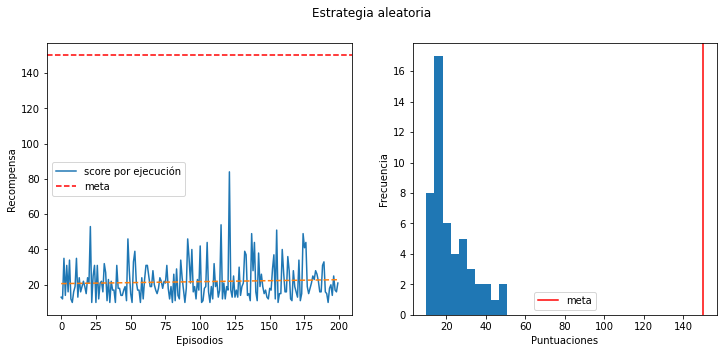

Episodio:199 Score:21.0
Después de 200 episodes la media de las recompensas es: 21.775


In [7]:
#Preparación del ambiente
final = []
title='Estrategia aleatoria'
episodes = 200
for episode in range(episodes):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
        if done:
                break

    #Acumula las recompensas
    final.append(score)
    plot_res(final,title)
        
    print('Episodio:{} Score:{}'.format(episode, score))
    
print(f"Después de 200 episodes la media de las recompensas es: {np.mean(final)}")

El primer gráfico traza la recompensa total que el agente acumula a lo largo del tiempo.
El segundo gráfico muestra un histograma de las recompensas totales del agente durante los últimos 200 episodios.

# 2. Crear una red neuronal con Keras

In [23]:
#Declaración de librerias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [24]:
#Definir función para crear la red
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [25]:
#LLamamos a función para construir el modelo
model = build_model(states, actions)

In [26]:
#Descripción del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 50,242
Trainable params: 50,242
Non-trainable params: 0
_________________________________________________________________


# 3. Construir el Agente con Keras-RL

In [54]:
#Declaración de librerias
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

In [55]:
#Keras-RL proporciona una clase llamada rl.memory/SequentialMemory que proporciona una estructura de datos rápida y 
#eficiente en la que podemos almacenar las experiencias del agente
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [56]:
#Construimos el agente
dqn = build_agent(model, actions)

In [57]:
#Compilamos el modelo del Agente
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [69]:
#Realizamos el entrenamiento
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: 1.0000
25 episodes - episode_reward: 395.760 [169.000, 500.000] - loss: 16.766 - mae: 65.892 - mean_q: 132.370

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: 1.0000
29 episodes - episode_reward: 336.621 [30.000, 500.000] - loss: 14.248 - mae: 60.261 - mean_q: 121.416

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: 1.0000
23 episodes - episode_reward: 446.043 [69.000, 500.000] - loss: 12.011 - mae: 57.874 - mean_q: 117.032

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 62s 6ms/step - reward: 1.0000
26 episodes - episode_reward: 384.423 [49.000, 500.000] - loss: 13.017 - mae: 58.157 - mean_q: 117.690

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: 1.000

In [70]:
#Guardamos los pesos
file_name = 'dqn_{}_weights.h5f'.format(env_name)
dqn.save_weights(file_name, overwrite=True)

In [71]:
dqn.history.history.keys()

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])

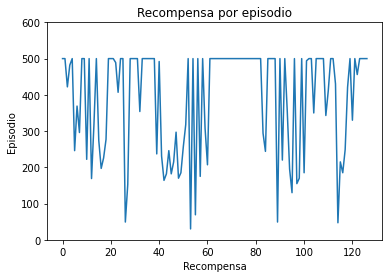

In [73]:
#Graficamos entrenamiento
plt.plot(dqn.history.history['episode_reward'])
plt.title('Recompensa por episodio')
plt.ylabel('Episodio')
plt.xlabel('Recompensa')
plt.ylim(0,600)
plt.show()

# 4. Realizar Test con el modelo entrenado

In [74]:
#Realizamos el testeo
scores = dqn.test(env, nb_episodes=100, visualize=False)
print("-------------------------------------")
print("Media:")
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 500.000, steps: 500
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 500.000, steps: 500
Episode 4: reward: 500.000, steps: 500
Episode 5: reward: 500.000, steps: 500
Episode 6: reward: 500.000, steps: 500
Episode 7: reward: 12.000, steps: 12
Episode 8: reward: 500.000, steps: 500
Episode 9: reward: 500.000, steps: 500
Episode 10: reward: 500.000, steps: 500
Episode 11: reward: 500.000, steps: 500
Episode 12: reward: 500.000, steps: 500
Episode 13: reward: 500.000, steps: 500
Episode 14: reward: 500.000, steps: 500
Episode 15: reward: 500.000, steps: 500
Episode 16: reward: 500.000, steps: 500
Episode 17: reward: 500.000, steps: 500
Episode 18: reward: 500.000, steps: 500
Episode 19: reward: 500.000, steps: 500
Episode 20: reward: 500.000, steps: 500
Episode 21: reward: 500.000, steps: 500
Episode 22: reward: 500.000, steps: 500
Episode 23: reward: 13.000, steps: 13
Episode 24: reward: 500.000, steps: 500
Episode 25: reward: 500.

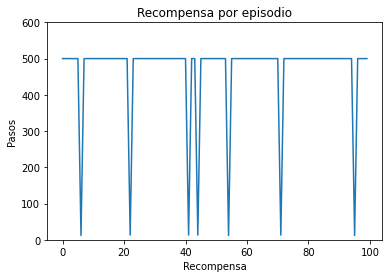

In [76]:
#Graficamos testeo
plt.plot(dqn.history.history['episode_reward'])
plt.title('Recompensa por episodio')
plt.ylabel('Pasos')
plt.xlabel('Recompensa')
plt.ylim(0,600)
plt.show()